## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [2]:
import string
import os
import numpy as np

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [3]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [4]:
sonnets = "".join(text).lower()

assert len(sonnets) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(sonnets) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In [5]:
sonnets[:100]

"  from fairest creatures we desire increase,\n  that thereby beauty's rose might never die,\n  but as "

In [6]:
tokens = sorted(set(sonnets))
id_to_token = {i: char for i, char in enumerate(tokens)}
token_to_id = {char: i for i, char in enumerate(tokens)}

### Data loading: "Евгений Онегин"


In [7]:
if not os.path.exists('onegin.txt'):
    !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [8]:
onegin = "".join(text).lower()

In [9]:
onegin[:100]

'\ni\n\n«мой дядя самых честных правил,\nкогда не в шутку занемог,\nон уважать себя заставил\nи лучше выдум'

Put all the characters, that you've seen in the text, into variable `tokens`.

In [10]:
tokens = sorted(set(onegin))
len(tokens)

83

In [11]:
tokens[:]

['\n',
 ' ',
 '!',
 '(',
 ')',
 ',',
 '-',
 '.',
 '5',
 '7',
 '8',
 '9',
 ':',
 ';',
 '?',
 '[',
 ']',
 '^',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '«',
 '»',
 'а',
 'б',
 'в',
 'г',
 'д',
 'е',
 'ж',
 'з',
 'и',
 'й',
 'к',
 'л',
 'м',
 'н',
 'о',
 'п',
 'р',
 'с',
 'т',
 'у',
 'ф',
 'х',
 'ц',
 'ч',
 'ш',
 'щ',
 'ъ',
 'ы',
 'ь',
 'э',
 'ю',
 'я',
 'ё',
 '–',
 '—',
 '’',
 '…',
 '€']

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [19]:
idx_to_token = {i: char for i, char in enumerate(tokens)}
token_to_idx = {char: i for i, char in enumerate(tokens)}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [21]:
def to_matrix(sentences, max_len = None, dtype='int32', batch_first=True):
    max_len = max_len or max(map(len, sentences))
    sentences_ix = np.zeros([len(sentences), max_len], dtype)

    for i in range(len(sentences)): # Для всех слов которые передали функции
        line_ix = [token_to_idx[c] for c in sentences[i]] #Кодируем слово
        sentences_ix[i, :len(line_ix)] = line_ix[:max_len] #Вставляем закодированное слово в матр
        # Вместо паддингов используем нули которые не меняются со времён формирования np.zeros
    if not batch_first: 
        sentences_ix = np.transpose(sentences_ix) #Транспонируем

    return sentences_ix

In [27]:
to_matrix(['hello, world'], max_len = None, dtype='int32', batch_first=True)

array([[25, 22, 28, 28, 31,  5,  1, 39, 31, 34, 28, 21]], dtype=int32)

### Building the model

In [28]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import random

device = 'cpu'

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [29]:
embed = nn.Embedding(4,2)
sample = torch.LongTensor([2])
next(embed.parameters())

Parameter containing:
tensor([[ 0.9954, -0.8658],
        [ 0.2101,  0.1454],
        [ 0.2511, -0.5010],
        [-0.3462,  0.0614]], requires_grad=True)

In [30]:
embed(sample)
#Т.е. это просто матрица эмбеддингов, которая из 4мерного пространства переводит в 2мерное.
# В нашей задаче она из 38мерного пр-ва переводит в 64мерное

tensor([[ 0.2511, -0.5010]], grad_fn=<EmbeddingBackward0>)

In [31]:
class CharRNNCell(nn.Module):
    #num_tokens -> размер словаря
    #embedding_size -> размер Эмбеддингов
    #rnn_num_units -> hidden size
    def __init__(self, num_tokens=len(tokens), embedding_size=64, rnn_num_units=512):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)#Любое число от0до38 в 64мерн.в-р
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)#Генерация h_t
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)#Линейный слой, принимающий h_t и выдающий 38 в-тей 
        
    def forward(self, x, h_prev):
        x_emb = self.embedding(x) #Input превразащется в набор эмбеддингов
        x_and_h = torch.cat([x_emb.to(device), h_prev.to(device)], dim=-1)#Конкатенируется с hidden_state_{t-1}
        h_next = self.rnn_update(x_and_h) #Обновляется hidden_state_{t}
        h_next = torch.tanh(h_next) #Обновляется hidden_state_{t}      
        logits = self.rnn_to_logits(h_next) #Новый hidden_state_{t} прогоняется через лин.слой для получения вероятностей
        return h_next, F.log_softmax(logits, -1) 
        #Возвращаем новый hidden_state_{t} для исп-я его в след итерации + все в-ти след. буквы
    
    def initial_state(self, batch_size): #Инициализация hidden_state_{0}  
        return torch.zeros(batch_size, self.num_units, device=device, requires_grad=True)

In [206]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters(), lr=1e-2)

def rnn_loop(char_rnn, batch_ix):#char_rnn-модель, batch_ix-длинная последовательность закодированных букв
    batch_size, _ = batch_ix.size()#длина текста, 1. Тут под словом батч подразумевается размер букв кот подаётся
    hid_state = char_rnn.initial_state(batch_size)#тензор (длина текста, hidden_size)
    logprobs = []

    for x_t in batch_ix.transpose(0, 1): #Начинаем бежать по буквам текста
        hid_state, logp_next = char_rnn(x_t, hid_state)#И для каждой делаем шаг RNN
        logprobs.append(logp_next) #Для каждой буквы, входящей в RNN мы получаем 83в-ти след буквы
        # logprobs shape = (длина текста, размер словаря)
    return torch.stack(logprobs, dim=1) #shape = (длина текста, 1, размер словаря)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [201]:
# batch_ix = to_matrix(onegin) #Кодируем текст онегина
# batch_ix = torch.tensor(batch_ix, dtype=torch.int64) #Переводим в тензор

# logp_seq = rnn_loop(char_rnn, batch_ix.to(device)) #Прогоняем и получам тензор(len(onegin), 1, размер словаря)

# predictions_logp = logp_seq[:, :-1] #Прогнозы след. токенов
# actual_next_tokens = batch_ix[:, 1:] #Реальные токены которые шли на том этапе

# loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), 
#                   actual_next_tokens.contiguous().view(-1)) #Переводим их к удобной для подсчёта лосса форме
# print(loss)

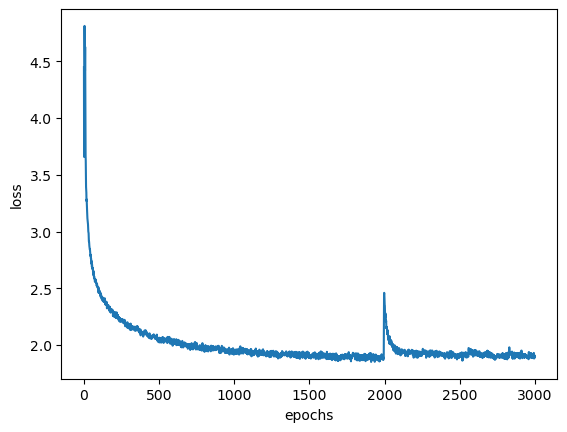

In [207]:
loss_history = []

for i in range(3000): #3000 циклов обучения
    sub_str = []
    #Генерим 128 фрагментов Онегина длиной 63 буквы
    for _ in range(200):
        # 128 раз генерим случ число от 0 до len(onegin) - 64 + 1
        idx = random.randrange(0, len(onegin) - 100 + 1)
        #В sub_str вставляем фрагмент текста, начиная с idx и + 63 буквы вперёд
        sub_str.append(onegin[idx : (idx + 100)]) 
    
    batch_ix = to_matrix(sub_str, max_len=100)#Кодируем это всё числами
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)#Переводим в тензор shape(128, 64)
    
    #Прогоняем наши 128 отрывков длиной 64 буквы через RNN и получаем тензор(128, 64, 83)
    #Это тензор прогнозов
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    predictions_logp = logp_seq[:, :-1] #Логиты (возможно надо поставить запятую перед -1)
    actual_next_tokens = batch_ix[:, 1:] #Реальные значения
    # В лосс подаём логиты размером(128*64, длина словаря) и фактич. буквы shape([128*64])
    # NLLLoss сам внутри себя берём макс значения из логитов и сопоставляет с прогнозами
    loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), actual_next_tokens.contiguous().view(-1))
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    #loss_value = loss.data.cpu().numpy()
    
    loss_history.append(loss.data.cpu().numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(loss_history)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()

In [212]:
seed_phrase = 'чем меньше женщину мы любим'
def generate_sample(char_rnn, seed_phrase=seed_phrase, max_length=MAX_LENGTH, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    x_sequence = [token_to_idx[token] for token in seed_phrase] #Кодируем стартовую фразу
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device) #Переводим в тензор
    hid_state = char_rnn.initial_state(batch_size=1) #Начальное скрытое состояние
    
    #Процесс изучения стартовой фразы
    for i in range(len(seed_phrase) - 1): #Побуквенно скармливаем в RNN нашу стартовую фразу
        hid_state, out = char_rnn(x_sequence[:, i], hid_state)
    
    #Процесс гереации текста длиной 'max_length' после стартовой фразы
    for _ in range(max_length - len(seed_phrase)):
        #Скармливаем последнюю букву стартовой фразы
        hid_state, out = char_rnn(x_sequence[:, -1], hid_state) 
        #Оборачиваем в softmax
        p_next = F.softmax(out / temperature, dim=-1).data.cpu().numpy()[0]
        #Рандомный прогноз след буквы(токена)
        next_ix = np.random.choice(len(tokens), p=p_next) 
        #Обрачиваем в тензор
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device) 
        #Засовываем в закодированный текст.На след итерации цикла мы её скормим нашей RNN и снова выберем новую букву
        x_sequence = torch.cat([x_sequence, next_ix], dim=1) 
    # Переводим сгенерированную последовательность в текст
    result = ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0] if tokens[ix] != "_"])
    
    return result

In [213]:
# An example of generated text.
print(generate_sample(char_rnn, seed_phrase=seed_phrase, max_length=270, temperature=1.0))

чем меньше женщину мы любим еще отдав,
убводился четован.
поятом ноговор ей доля всё, бурей,
ко яслесно ниждий с умливовогдо тво учер,
любви мой, бердевье тревересший,
кто быть, и юнотей;
чтобный пад,
весных (санье,
ему, как я; пирою
или и разверхи тан? я… ктонилсей зав


# Комментарий:
Как мы видим, простой RNN сложно воссоздавать реальные слова. Скорее всего причиной этому является отсутствие возможности хранить долгосрочную память

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [215]:
class CharLSTMCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), emb_size=64, lstm_num_units=512):
        super(self.__class__, self).__init__()
        self.num_units = lstm_num_units #hidden size
        self.emb = nn.Embedding(len(tokens), emb_size) #embedding layer(83->64)
        self.lstm = nn.LSTM(emb_size, self.num_units, batch_first=True)#LSTM(input_size, hidden_size, num_layers=1)
        
        self.hid_to_logits = nn.Linear(self.num_units, num_tokens) #Перевод hidden в логиты

    def forward(self, x, hidden=None):
        #засовываем в lstm эмбеддинг буквы и hidden_state_{t-1}
        h_seq, hidden = self.lstm(self.emb(x), hidden)
        #пускаем h_seq в лин.слой и получаем логиты
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp, hidden #Логиты, hidden_state

    def initial_state(self, batch_size):# Инициализация стартового hidden_state_{0}
        return torch.zeros(batch_size, self.num_units, device=device, requires_grad=True)

Plot the loss function of the number of epochs. Does the final loss become better?

In [216]:
char_lstm = CharLSTMCell().to(device)
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_lstm.parameters(), lr=3e-4)

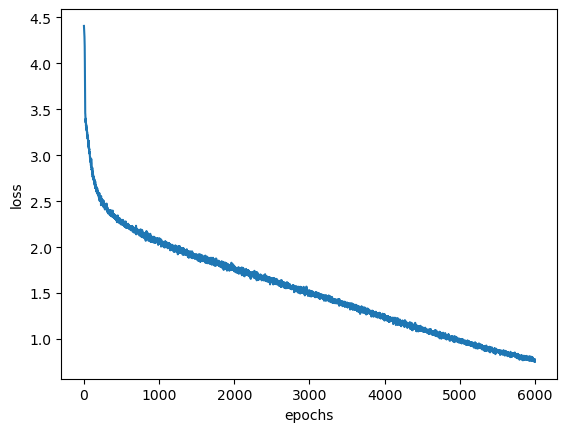

In [217]:
lstm_loss_history = []

for i in range(6000): #6т циклов обучения
    train_string = []
    for _ in range(128): #128 отрывков длиной 63
        idx = random.randrange(0, len(onegin) - 64 + 1)
        train_string.append(onegin[idx : (idx + 64)])
    
    batch_ix = to_matrix(train_string, max_len=64) #кодировка в числовую последовательность
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq, _ = char_lstm(batch_ix) #выход модели
    predictions_logp = logp_seq[:, :-1] #прогнозы
    actual_next_tokens = batch_ix[:, 1:]#факты
    #подсчёт лосса
    loss = criterion(predictions_logp.contiguous().view(-1, len(tokens)), actual_next_tokens.contiguous().view(-1))
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    lstm_loss_history.append(loss.data.cpu().numpy())
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(lstm_loss_history)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()

# Комментарий:
Как мы видим, даже 6000 обучающих итераций не хватило, что бы loss вышел на плато.Однако переучивать модель тоже не следует, так как она может запомнить весь текст.

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [219]:
seed_phrase='чем меньше женщину мы любим'
def generate_sample_lstm(char_lstm, seed_phrase=seed_phrase, max_length=100, temperature=1.0):
    x_sequence = [token_to_idx[token] for token in seed_phrase]#Кодировка стартовой последовательности
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)#Перевод в тезор
    
    h_state = torch.zeros(1, 1, char_lstm.num_units, device=device) #Генерация краткосрочной памяти
    c_state = torch.zeros(1, 1, char_lstm.num_units, device=device) #Генерация долгосрочной памяти

    # Побуквенно скармливаем сети нашу seed_phrase
    for i in range(len(seed_phrase) - 1):
        _, (h_state, c_state) = char_lstm(x_sequence[:, i].unsqueeze(0), (h_state, c_state))

    for i in range(max_length - len(seed_phrase)):
        logits, (h_state, c_state) = char_lstm(x_sequence[:, -1].unsqueeze(0), (h_state, c_state))
        p_next = F.softmax(logits / temperature, dim=-1).data.cpu().numpy()[0]
        next_ix = np.random.choice(len(tokens), p=p_next.ravel())
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64).to(device)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)

    result = ''.join([tokens[ix] for ix in x_sequence.data.cpu().numpy()[0] if tokens[ix] != "_"])
    return result


In [220]:
result = generate_sample_lstm(char_lstm, seed_phrase='чем меньше женщину мы любим', max_length=500, temperature=0.1)
print(result)

чем меньше женщину мы любим,
тем легче насторул я встретя,
в вас горей под ней не изменил
он в пестях мое весел,
я продочет с береговая,
догоброй воленивый вздор,
верной нет, ней девы слезы лью,
твой огонья готовит слов,
с досердца своенравие природной,
не муза и луни были дале
иль полно избрать с обедом,
и сад и бледный прощали,
осталася татьяна сполит;
он в сельей вновь, не знает кона
и в старой нет. о немогом
зарецкий жизни ликаход,
стал подобна пред ними слева,
все длинных страстей руклах ур


In [227]:
result = generate_sample_lstm(char_lstm, seed_phrase='чем меньше женщину мы любим', max_length=500, temperature=0.2)
print(result)

чем меньше женщину мы любим,
тем любительно от рассейки млады,
аль воспомир, и мельденица
вот уж блистая, шайкает —
и, невольно был он между тем
не тоже теберный лорнатом
и наконец от них отец
из искал в салот себе вечар,
или предстанет на что жена
не всё, что в раздался и блажен,
что там душа?» – «на слезот промлана
во всех полет и в постеле
ни к ним ro cesterabe и самов,
всё вечалась о точки мил.



xxvi

«ужели татьяна понимать
то делят и них на больше отрада,
веселы приносит намечет,
как буд


In [224]:
result = generate_sample_lstm(char_lstm, seed_phrase='чем меньше женщину мы любим', max_length=500, temperature=0.5)
print(result)

чем меньше женщину мы любим;
татьяно лени был дерденный души,
в грандисон был голов и страдал,
иль должны был обедом в самом
друг дому ей онегин уж отворя
сердца живы и начал.



xi

в том прозыбк е глупествованье,
две согласиной в томите
приходит про любовью угоду,
девицы проходил он ее,
и ворот в саду бледный ларин,
извиже изменина;
но в слезах лишь ее природной,
татьяна бергенов, ни бал,
но, недовлевь меня ободить,
слава богою: друзья совестве,
вот меня волнем обведалася,
покамест в молвило о


In [225]:
result = generate_sample_lstm(char_lstm, seed_phrase='чем меньше женщину мы любим', max_length=500, temperature=1.0)
print(result)

чем меньше женщину мы любим,
тепер, потоми но моей
забедит ровкивый он полю
из мной сора твой ид уток.
вот берет, всю вошле ветрелает
и в сам покойникам возок:
врайце он уж отворилась.



xviii

он равно дела; евгений,
когда бы важный признанья,
любви несною мечтанья,
и наши верной новый рим;
у с ольгой; и входит он
увял сём ваши новигит:
«огон! довит?». — «на moacett.
из болеве, свой пиров
непроссиженной брозви.



xxxvi

но полно изоть различать;
старушки услажу я альма:
стоит нам навсегда с х


In [226]:
result = generate_sample_lstm(char_lstm, seed_phrase='чем меньше женщину мы любим', max_length=500, temperature=2.0)
print(result)

чем меньше женщину мы любим,
двеждайный? !менных четом?» —
«вала терперсвое сновенья?
чне тах мы сешей. трайум?

x
xxi
хиа музою своекой,
в женних кучишни, тстаки был:
я -пнимати:ск, кто-а суждсе…).
ма друм пьет?? кучае… : толвые цракй?»
rervi.
nan.
аl

и проледет мвог ведтечает цво?
порой зярну созданья, двал.
пусхой, слютснох, свечшей еей.



асонся лгоюдшкяюги дворов живвирькливовыноков,
б летс кеин),теск-ев-тико..
а
xиц-к ужигалю: поворуж!». —



мучало; роковнурез.
в, поют; кмучил тяжея?);



# Вывод :
Чем меньше температура, тем больше вероятность выбора самого большого логита и как следствеие - более адекватный текст. При поднятии температуры растёт вероятность выбора не первого по величине логита, а 2,3 и тд. Это всё приводит к менее осмысленной генерации текста. Этот эффект можно наблюдать на примерах выше, где по мере увелдичения температуры мы начинаем получать всё менее адекватный текст.

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [223]:
# Saving and loading code here
torch.save(char_lstm.state_dict(), 'char_lstm.pth')

new_lstm = CharLSTMCell()
new_lstm.load_state_dict(torch.load('char_lstm.pth'))

result = generate_sample_lstm(new_lstm, seed_phrase='придумывай', max_length=400, temperature=0.1)
print(result)

придумывай, то день моя,
татьяна встала в ней занимал,
ответно всё беговые ли?
давно утомить он малодит
и утра не унылый друзья!
его был разленить вас она.
«как ты, мого даны. – «нать?». – «нак!». – «на как и мак!
гда был потом падает —
и, полно, тревно гоновор,
иль про золот ее подвел
теснулся он он не совор,
и там же книгами знаком.



xv

но в он умы в себя с поредом,
в деревне, скло назраз и б


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)